In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import numpy as np

In [3]:
# ================================
# 1. ĐỌC DỮ LIỆU
# ================================
file_path = r'D:\Data_Paper_5G\DATA\CTKD.csv'
df = pd.read_csv(file_path)

In [5]:

selected_columns = [
    'DATETIME_ID',
    'TTML',
    'CTKD',
    'PS_CSSR_NR',
    'SDR_NR',
    'PRB_UTIL_DL_NR',     
    'PRB_UTIL_UL_NR',
    'LATENCY_NR',
    'PKTLOSSR',           
    'CONNECTED_RRC_USER_AVERAGE',
    'CONNECTED_RRC_USER_MAX',
    'DKD5G_NR',
    'EN_DC_SR_NR',
    'HOSR_NR',
    'RASR_NR',
    'DL_TRAFFIC_NR',
    'UL_TRAFFIC_NR',
    'USER_DL_THP_NR',
    'USER_UL_THP_NR',
    'CELL_DL_THP_NR',
    'CELL_UL_THP_NR'
]
df = df[selected_columns]

In [6]:
# Loại bỏ dòng có missing value ở các cột đã chọn
df = df.dropna(subset=selected_columns)
df = df.reset_index(drop=True)

In [7]:
print(f"Đã làm sạch dữ liệu: {df.shape[0]} dòng, {df.shape[1]} cột")
print("\n5 dòng đầu:")
print(df.head())

Đã làm sạch dữ liệu: 1460 dòng, 21 cột

5 dòng đầu:
   DATETIME_ID        TTML  CTKD  PS_CSSR_NR  SDR_NR  PRB_UTIL_DL_NR  \
0   2025040100  Mien Trung     7      100.00    0.00            1.78   
1   2025040100    Mien Bac     1      100.00    0.00            1.32   
2   2025040100    Mien Bac     4      100.00    0.00            0.27   
3   2025040100  Mien Trung     3       29.39    0.01            0.97   
4   2025040100    Mien Bac     5      100.00    0.00            0.92   

   PRB_UTIL_UL_NR  LATENCY_NR  PKTLOSSR  CONNECTED_RRC_USER_AVERAGE  ...  \
0            2.63   836975.19       0.0                      537.62  ...   
1            1.88    30207.19       0.0                     3375.37  ...   
2            0.39    14514.08       0.0                       16.21  ...   
3            0.78    39319.91       0.0                     5843.03  ...   
4            1.32    13313.76       0.0                      306.49  ...   

   DKD5G_NR  EN_DC_SR_NR  HOSR_NR  RASR_NR  DL_TRAFFIC_NR 

In [ ]:
# BASIC INFORMATION BLOCK 
# -------------------------------------------------
print("\nData information:")
print(df.info())

print("\nStatistical description:")
print(df.describe())

# Check missing values 
missing = df.isnull().sum()
print("\nMissing values (should be 0):")
print(missing[missing > 0])


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATETIME_ID                 1460 non-null   int64  
 1   TTML                        1460 non-null   object 
 2   CTKD                        1460 non-null   int64  
 3   PS_CSSR_NR                  1460 non-null   float64
 4   SDR_NR                      1460 non-null   float64
 5   PRB_UTIL_DL_NR              1460 non-null   float64
 6   PRB_UTIL_UL_NR              1460 non-null   float64
 7   LATENCY_NR                  1460 non-null   float64
 8   PKTLOSSR                    1460 non-null   float64
 9   CONNECTED_RRC_USER_AVERAGE  1460 non-null   float64
 10  CONNECTED_RRC_USER_MAX      1460 non-null   int64  
 11  DKD5G_NR                    1460 non-null   float64
 12  EN_DC_SR_NR                 1460 non-null   float64
 13  HOSR_NR       

In [20]:
# 2. BASIC PRE-PROCESSING
# ================================
# Convert DATETIME_ID to datetime
df['DATETIME_ID'] = pd.to_datetime(df['DATETIME_ID'], format='%Y%m%d%H')

# Extra columns for plotting
df['DATE'] = df['DATETIME_ID'].dt.date
df['HOUR'] = df['DATETIME_ID'].dt.hour

# Group by TTML and CTKD for hierarchical analysis (e.g., mean KPIs per region/sub-region)
grouped = df.groupby(['TTML', 'CTKD']).agg({
    'USER_DL_THP_NR': 'mean',
    'LATENCY_NR': 'mean',
    'CONNECTED_RRC_USER_AVERAGE': 'mean'
}).reset_index()

print("\nHierarchical Summary (Mean KPIs by TTML and CTKD):")
print(grouped.head(10))  # Show top 10 for example

# Optional: Simple outlier removal (e.g., remove rows where USER_DL_THP_NR > 3 std devs)
std_dev = df['USER_DL_THP_NR'].std()
mean_val = df['USER_DL_THP_NR'].mean()
df = df[(df['USER_DL_THP_NR'] > mean_val - 3 * std_dev) & (df['USER_DL_THP_NR'] < mean_val + 3 * std_dev)]


Hierarchical Summary (Mean KPIs by TTML and CTKD):
         TTML  CTKD  USER_DL_THP_NR    LATENCY_NR  CONNECTED_RRC_USER_AVERAGE
0    Mien Bac     1      312.646099  10154.347418                 7006.800275
1    Mien Bac     4      186.162486   8990.262873                  457.743039
2    Mien Bac     5      178.727582   8521.222088                 4884.737253
3    Mien Nam     2      335.974945  12883.456484                41586.149890
4    Mien Nam     8      320.378689  10329.774699                15250.268415
5    Mien Nam     9      286.411257   9091.347322                12859.393279
6  Mien Trung     3      175.051639  12744.039781                12197.015301
7  Mien Trung     7      352.079725  12677.658407                 1734.282308


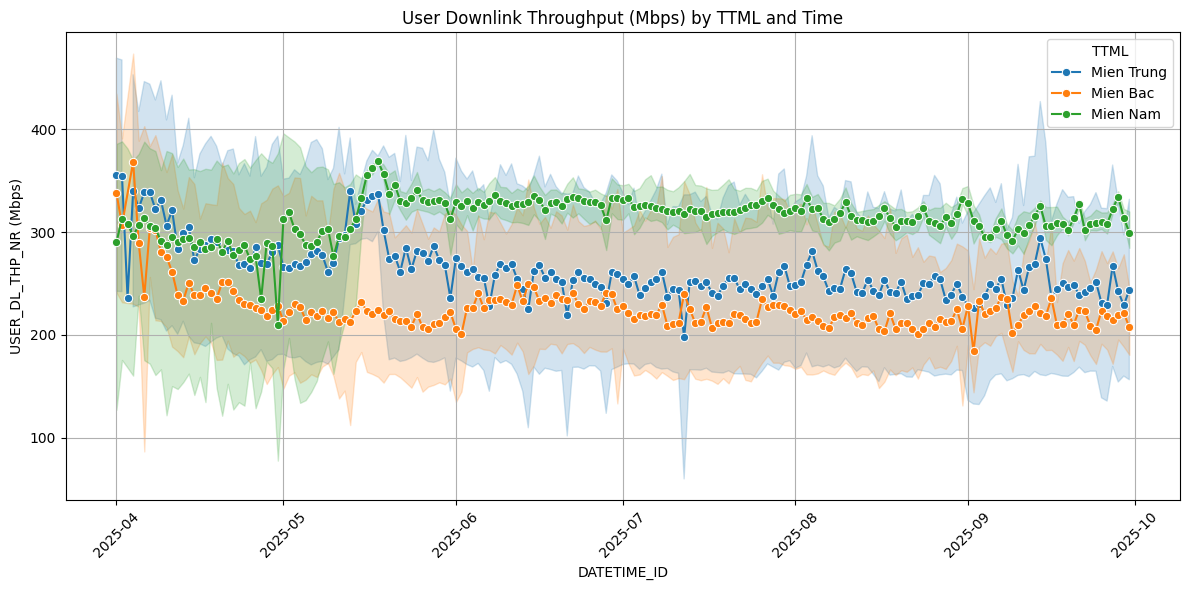

In [26]:
# 3. EXPLORATORY VISUALISATIONS (Updated for CTKD hierarchy)
# ================================

# Plot 1: USER_DL_THP_NR by TTML over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='DATETIME_ID', y='USER_DL_THP_NR', hue='TTML', marker='o')
plt.title('User Downlink Throughput (Mbps) by TTML and Time')
plt.xticks(rotation=45)
plt.ylabel('USER_DL_THP_NR (Mbps)')
plt.legend(title='TTML')
plt.grid(True)
plt.tight_layout()
plt.show()


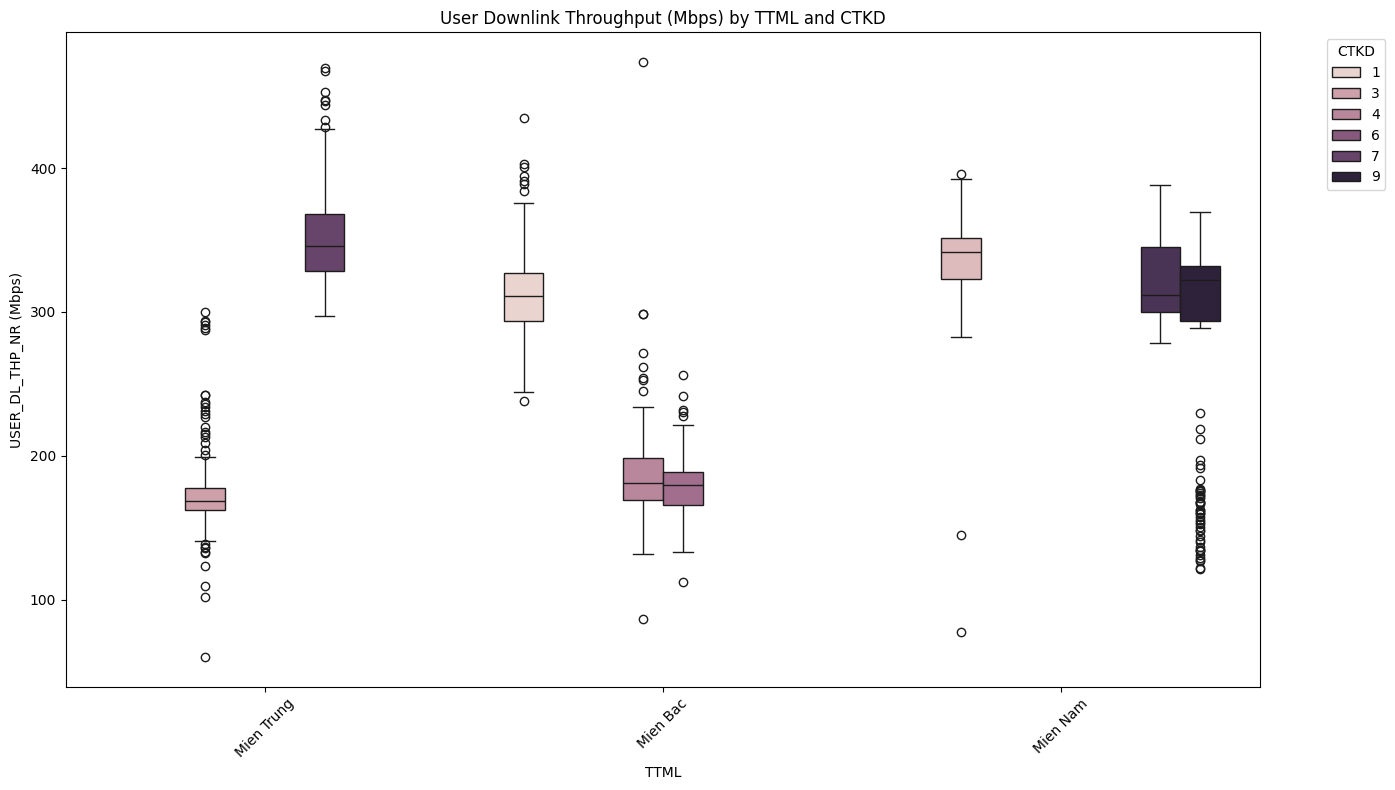

In [30]:

# New Plot: USER_DL_THP_NR by CTKD within TTML (boxplot for hierarchy)
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='TTML', y='USER_DL_THP_NR', hue='CTKD')
plt.title('User Downlink Throughput (Mbps) by TTML and CTKD')
plt.xticks(rotation=45)
plt.ylabel('USER_DL_THP_NR (Mbps)')
plt.legend(title='CTKD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


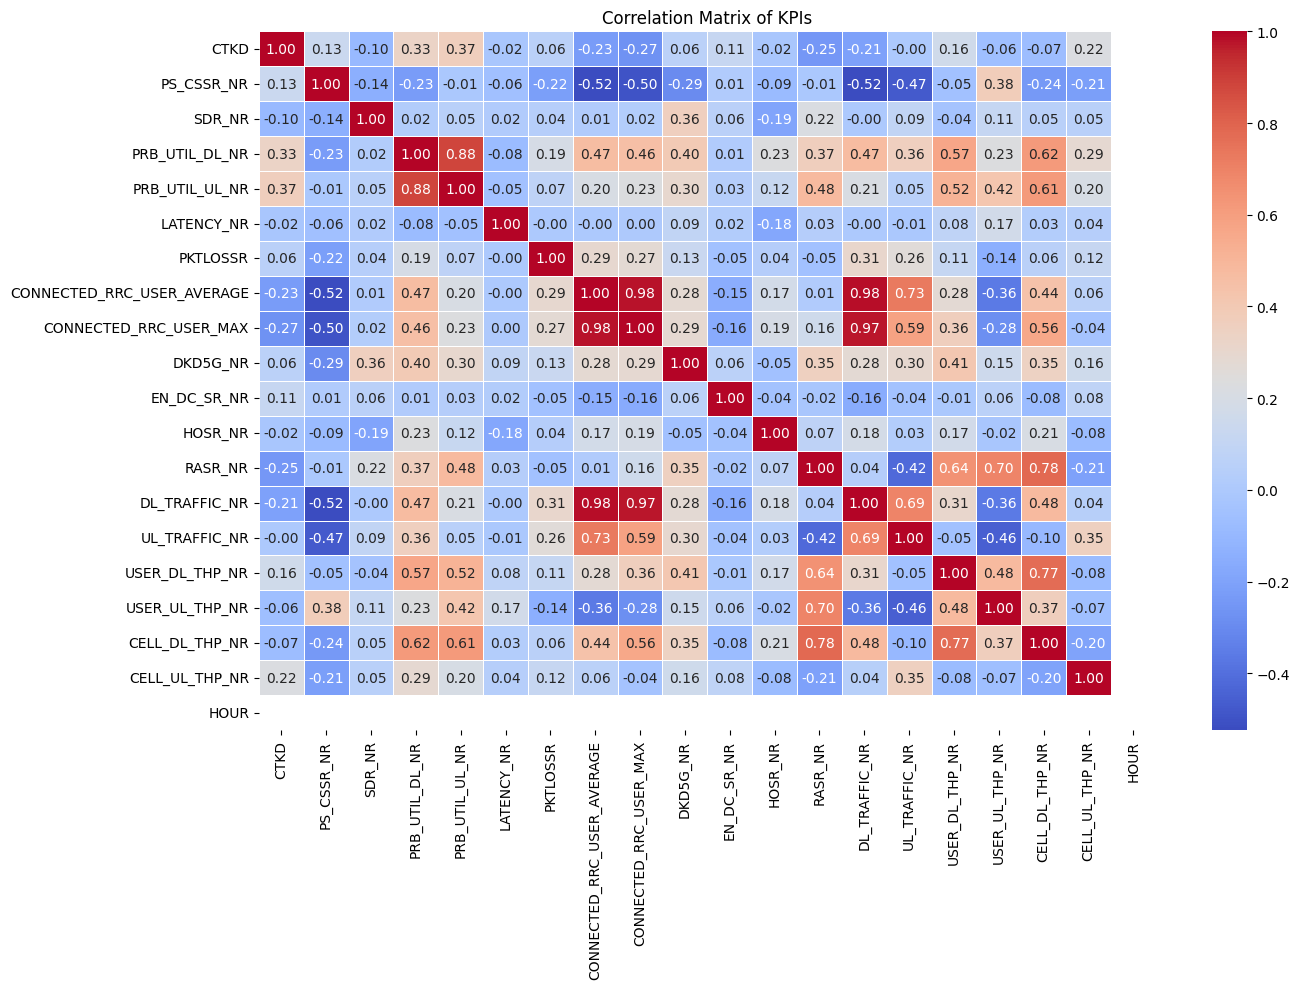

In [31]:

# Plot 2: Correlation heatmap (numeric columns only)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of KPIs')
plt.tight_layout()
plt.show()


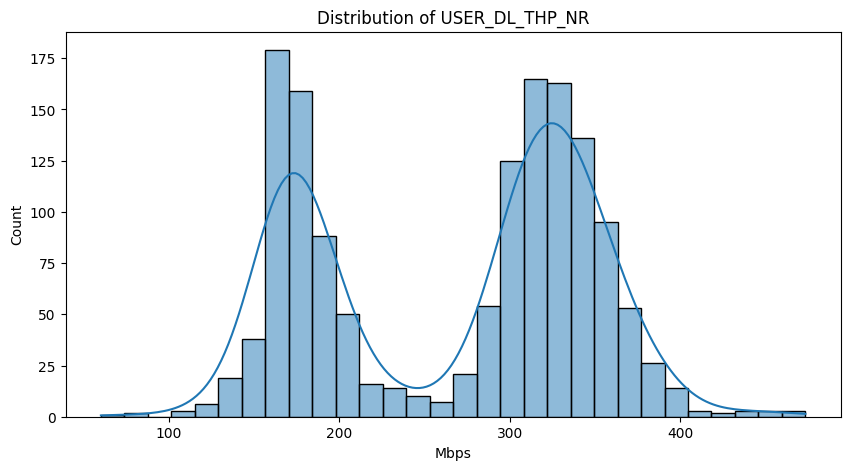

In [32]:

# Plot 3: Distribution of USER_DL_THP_NR
plt.figure(figsize=(10, 5))
sns.histplot(df['USER_DL_THP_NR'], kde=True, bins=30)
plt.title('Distribution of USER_DL_THP_NR')
plt.xlabel('Mbps')
plt.show()


Feature columns after encoding:
['PS_CSSR_NR', 'SDR_NR', 'PRB_UTIL_DL_NR', 'PRB_UTIL_UL_NR', 'LATENCY_NR', 'PKTLOSSR', 'CONNECTED_RRC_USER_AVERAGE', 'CONNECTED_RRC_USER_MAX', 'DKD5G_NR', 'EN_DC_SR_NR', 'HOSR_NR', 'RASR_NR', 'DL_TRAFFIC_NR', 'UL_TRAFFIC_NR', 'CELL_DL_THP_NR', 'CELL_UL_THP_NR', 'REGION_TTML_Mien Bac', 'REGION_TTML_Mien Nam', 'REGION_TTML_Mien Trung', 'REGION_CTKD_1', 'REGION_CTKD_2', 'REGION_CTKD_3', 'REGION_CTKD_4', 'REGION_CTKD_5', 'REGION_CTKD_7', 'REGION_CTKD_8', 'REGION_CTKD_9']

=== RANDOM FOREST RESULTS ===
Mean Squared Error: 502.9917
R² Score: 0.9186


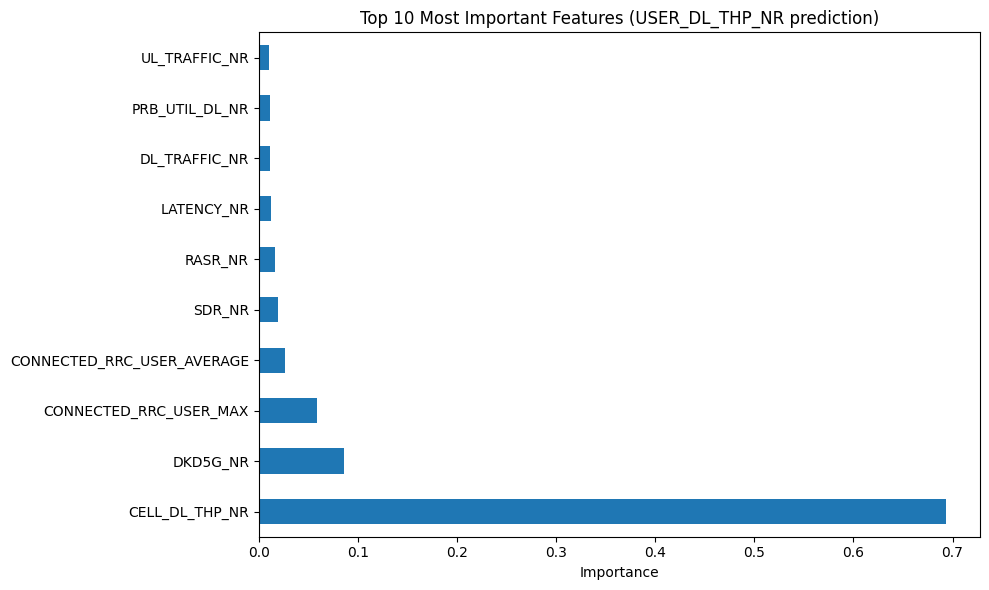

In [33]:
# 4. RANDOM FOREST PREDICTION (target = USER_DL_THP_NR, with CTKD encoded)
# ================================

target = 'USER_DL_THP_NR'

# Feature columns (numeric + one-hot for TTML and CTKD)
feature_cols = [
    'PS_CSSR_NR', 'SDR_NR', 'PRB_UTIL_DL_NR', 'PRB_UTIL_UL_NR',
    'LATENCY_NR', 'PKTLOSSR', 'CONNECTED_RRC_USER_AVERAGE',
    'CONNECTED_RRC_USER_MAX', 'DKD5G_NR', 'EN_DC_SR_NR',
    'HOSR_NR', 'RASR_NR', 'DL_TRAFFIC_NR', 'UL_TRAFFIC_NR',
    'CELL_DL_THP_NR', 'CELL_UL_THP_NR'
]

# One-Hot encode both TTML and CTKD (hierarchical categories)
df_encoded = pd.get_dummies(df, columns=['TTML', 'CTKD'], prefix=['REGION_TTML', 'REGION_CTKD'])

# Add dummies to feature list
feature_cols += [c for c in df_encoded.columns if c.startswith('REGION_')]

# Print feature columns for debugging
print("\nFeature columns after encoding:")
print(feature_cols)

X = df_encoded[feature_cols]
y = df_encoded[target]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest (increased n_estimators for better performance with more features)
model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== RANDOM FOREST RESULTS ===")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance (top 10)
importances = pd.Series(model.feature_importances_, index=feature_cols)
top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='barh')
plt.title('Top 10 Most Important Features (USER_DL_THP_NR prediction)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [34]:
# 5. PREDICT A NEW RECORD (example, with CTKD) - FIXED STRUCTURE
# ================================
new_record = {
    'PS_CSSR_NR': 99.5,
    'SDR_NR': 0.1,
    'PRB_UTIL_DL_NR': 1.5,
    'PRB_UTIL_UL_NR': 1.8,
    'LATENCY_NR': 20000,
    'PKTLOSSR': 0.0,
    'CONNECTED_RRC_USER_AVERAGE': 5000,
    'CONNECTED_RRC_USER_MAX': 20000,
    'DKD5G_NR': 98.5,
    'EN_DC_SR_NR': 99.8,
    'HOSR_NR': 95.0,
    'RASR_NR': 98.0,
    'DL_TRAFFIC_NR': 2.5e7,
    'UL_TRAFFIC_NR': 2.0e6,
    'CELL_DL_THP_NR': 300,
    'CELL_UL_THP_NR': 15,
    # All TTML dummies (set 1 for selected, 0 for others)
    'REGION_TTML_Mien Bac': 1,
    'REGION_TTML_Mien Nam': 0,
    'REGION_TTML_Mien Trung': 0,
    # All CTKD dummies (set 1 for selected, 0 for others; based on unique values: 1,2,3,4,5,7,8,9)
    'REGION_CTKD_1': 1,
    'REGION_CTKD_2': 0,
    'REGION_CTKD_3': 0,
    'REGION_CTKD_4': 0,
    'REGION_CTKD_5': 0,
    'REGION_CTKD_7': 0,
    'REGION_CTKD_8': 0,
    'REGION_CTKD_9': 0
}

new_df = pd.DataFrame([new_record])
# Reindex to match X columns exactly (fill missing with 0)
new_df = new_df.reindex(columns=X.columns, fill_value=0)

pred = model.predict(new_df)[0]
print(f"\nPREDICTION for new record: USER_DL_THP_NR ≈ {pred:.2f} Mbps")


PREDICTION for new record: USER_DL_THP_NR ≈ 368.06 Mbps
